# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [1]:
!pip install PyWavelets
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2
ERROR: No matching distribution found for cv2


In [2]:
import pywt

pywt.__version__

'1.1.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [3]:
# Your code here
...
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

duration = 2.5  # seconds
sampling_rate = 20000  # Hz
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)


frequencies = [10, 30, 60, 30, 10]  # Hz
segment_duration = 0.5  # seconds
signal = np.concatenate([
    np.sin(2 * np.pi * freq * time[int(i * segment_duration * sampling_rate):int((i + 1) * segment_duration * sampling_rate)])
    for i, freq in enumerate(frequencies)
])

display(Audio(signal, rate=sampling_rate))



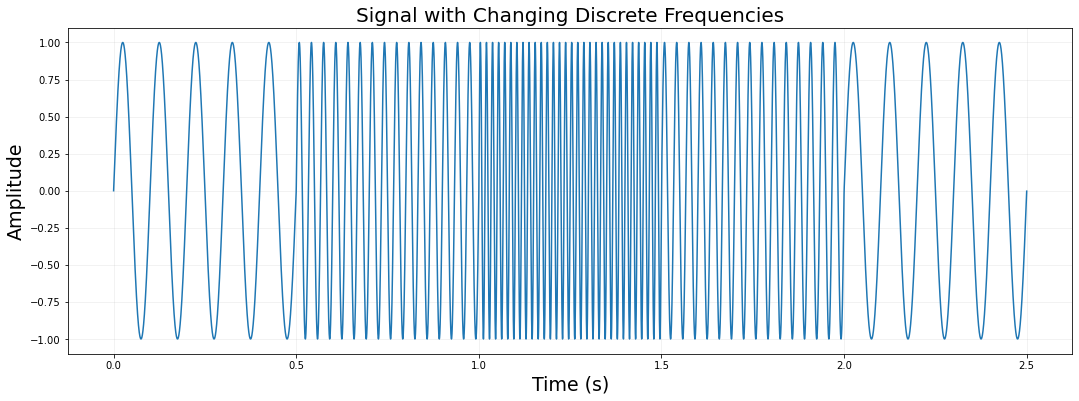

In [4]:
import matplotlib
import matplotlib.pyplot as plt

font_size = 20

plt.figure(figsize=(18, 6))

plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

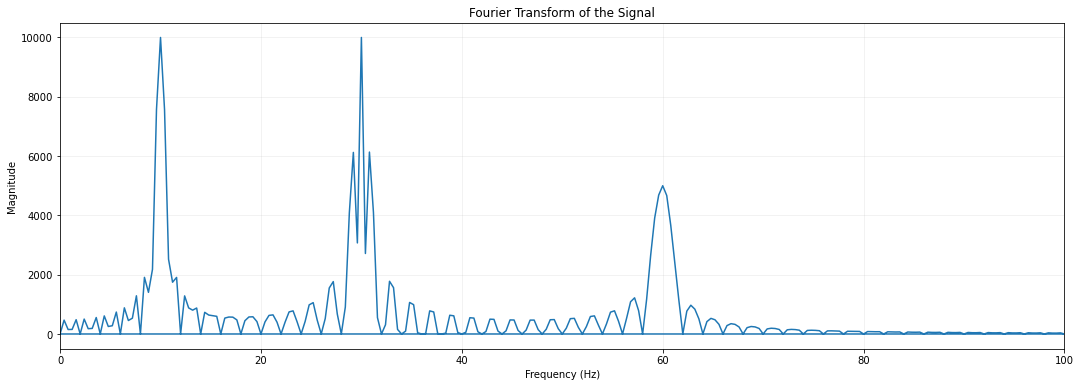

In [5]:
# Your code here
...
FT_signal = np.fft.fft(signal)
freq = np.fft.fftfreq(len(FT_signal), 1/sampling_rate) 
plt.figure(figsize=(18, 6))
plt.plot(freq, np.abs(FT_signal))
plt.title('Fourier Transform of the Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 100)
plt.grid(alpha=0.2)
plt.show()



**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) In our case fmax is equal to 60Hz. Since 2*60=120<Fs=20000, the Nyquist-Shannon theorem is met.

2) Looking only at it we can say that we have 3 frequencies located around 10 30 and 60Hz.

3) It is not possible due to the time/frequency duality (or Heisenberg inequality). We have a quiet good knowledge of the frequencies so we can not have a decent information on time.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

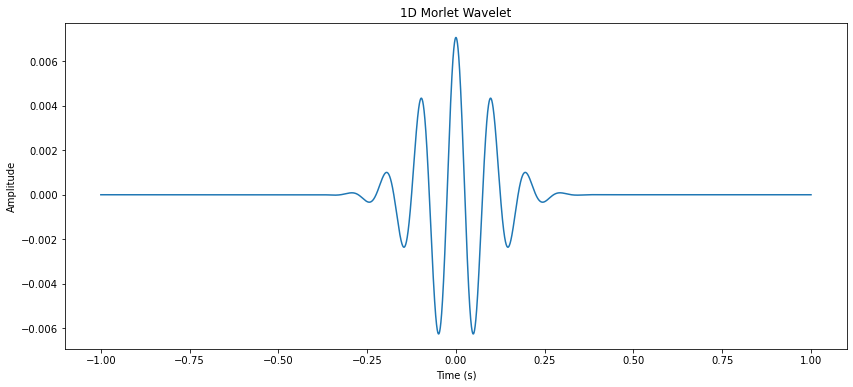

In [5]:
# Your code here
...
eta = 20000 # Hz
k = 1/np.sqrt(eta)
sigma = 0.1
w0 = 2*np.pi*10

t = np.linspace(-1, 1, 2 * sampling_rate, endpoint=False)

psi = k * np.exp( w0 * 1j * t) * np.exp(-t**2 / (2 * sigma**2))

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(t, psi.real, linewidth=1.5)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [22]:
# Your code here
...
mean = np.mean(psi)

print(f'The mean of the Morlet wavelet is: {mean}')

energy = np.sum(np.abs(psi)**2)

print(f'The energy of the Morlet wavelet is: {energy}')

The mean of the Morlet wavelet is: (2.3709122438003404e-12-1.738134697866389e-20j)
The energy of the Morlet wavelet is: 0.17724538509055163


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

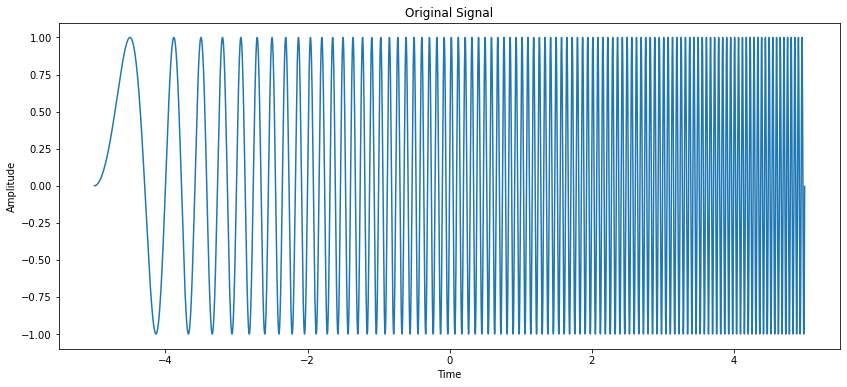

In [7]:
# Your code here
...
time_signal = np.linspace(-5, 5, 10 * sampling_rate, endpoint=False)
n = len(time_signal)
freqs = np.linspace(5,15,n)
signal = np.sin(2 * np.pi * freqs * time_signal)

plt.figure(figsize=(14, 6))
plt.plot(time_signal, signal)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

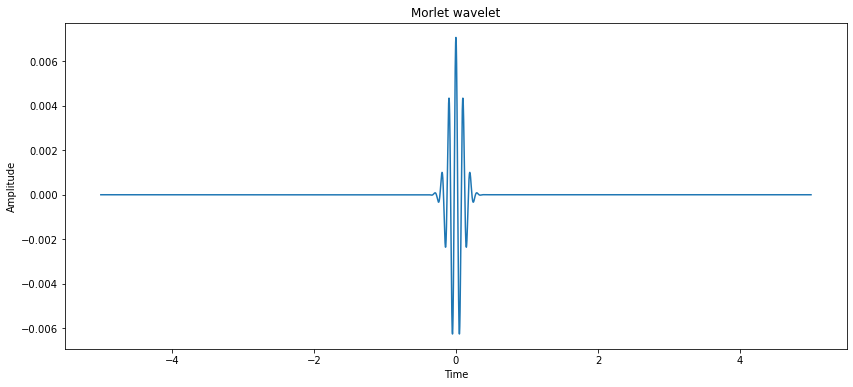

In [10]:
# Your code here
morlet_wavelet = k * np.exp( w0 * 1j * time_signal) * np.exp(-time_signal**2 / (2 * sigma**2))

plt.figure(figsize=(14, 6))
plt.plot(time_signal, np.real(morlet_wavelet))

plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

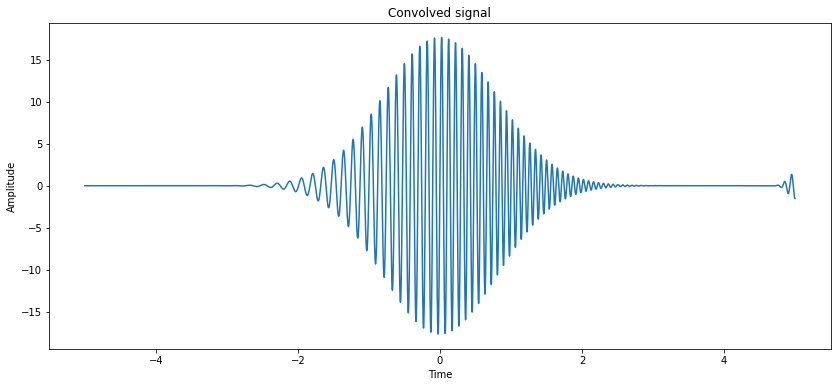

In [11]:
# Your code here
convolved_signal = np.convolve(signal, morlet_wavelet.real, mode='same') 

plt.figure(figsize=(14, 6))
plt.plot(time_signal, convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

Answer: It is normal since we were using only the real part. We can then either use a 3d plot to visualize the complex values or use the absolute value of the convolved signal which will give us the enveloppe of the real part.

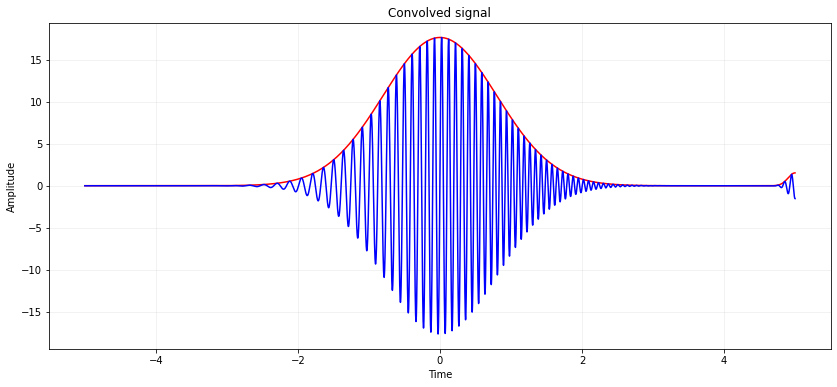

In [ ]:
# Your code here
convolved_signal = np.convolve(signal, morlet_wavelet, mode='same')

plt.figure(figsize=(14, 6))
plt.plot(time_signal, abs(convolved_signal), c='r')
plt.plot(time_signal, convolved_signal.real , c='b')
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [23]:
!wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [10]:

import pywt
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

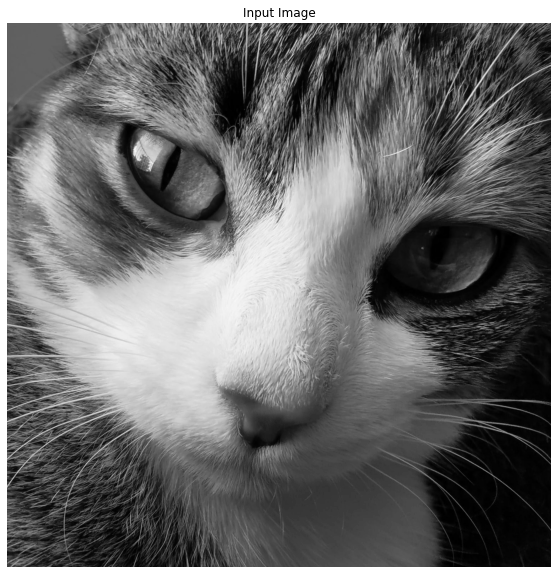

In [11]:

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


input_image = Image.open('Trudy_for_compression.jpeg').convert('L')
input_image = np.array(input_image)

show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [7]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [29]:
# For each family, you can list the available wavelets
pywt.wavelist(family='db', kind='all')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.



**YOUR ANSWER HERE:**

We get in order top left, top right, bottom left, bottom right: low frequencies of the image (original image filtered by a low pass), vertical high frequencies, horizontal high frequencies, diagonal high frequencies. 


Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

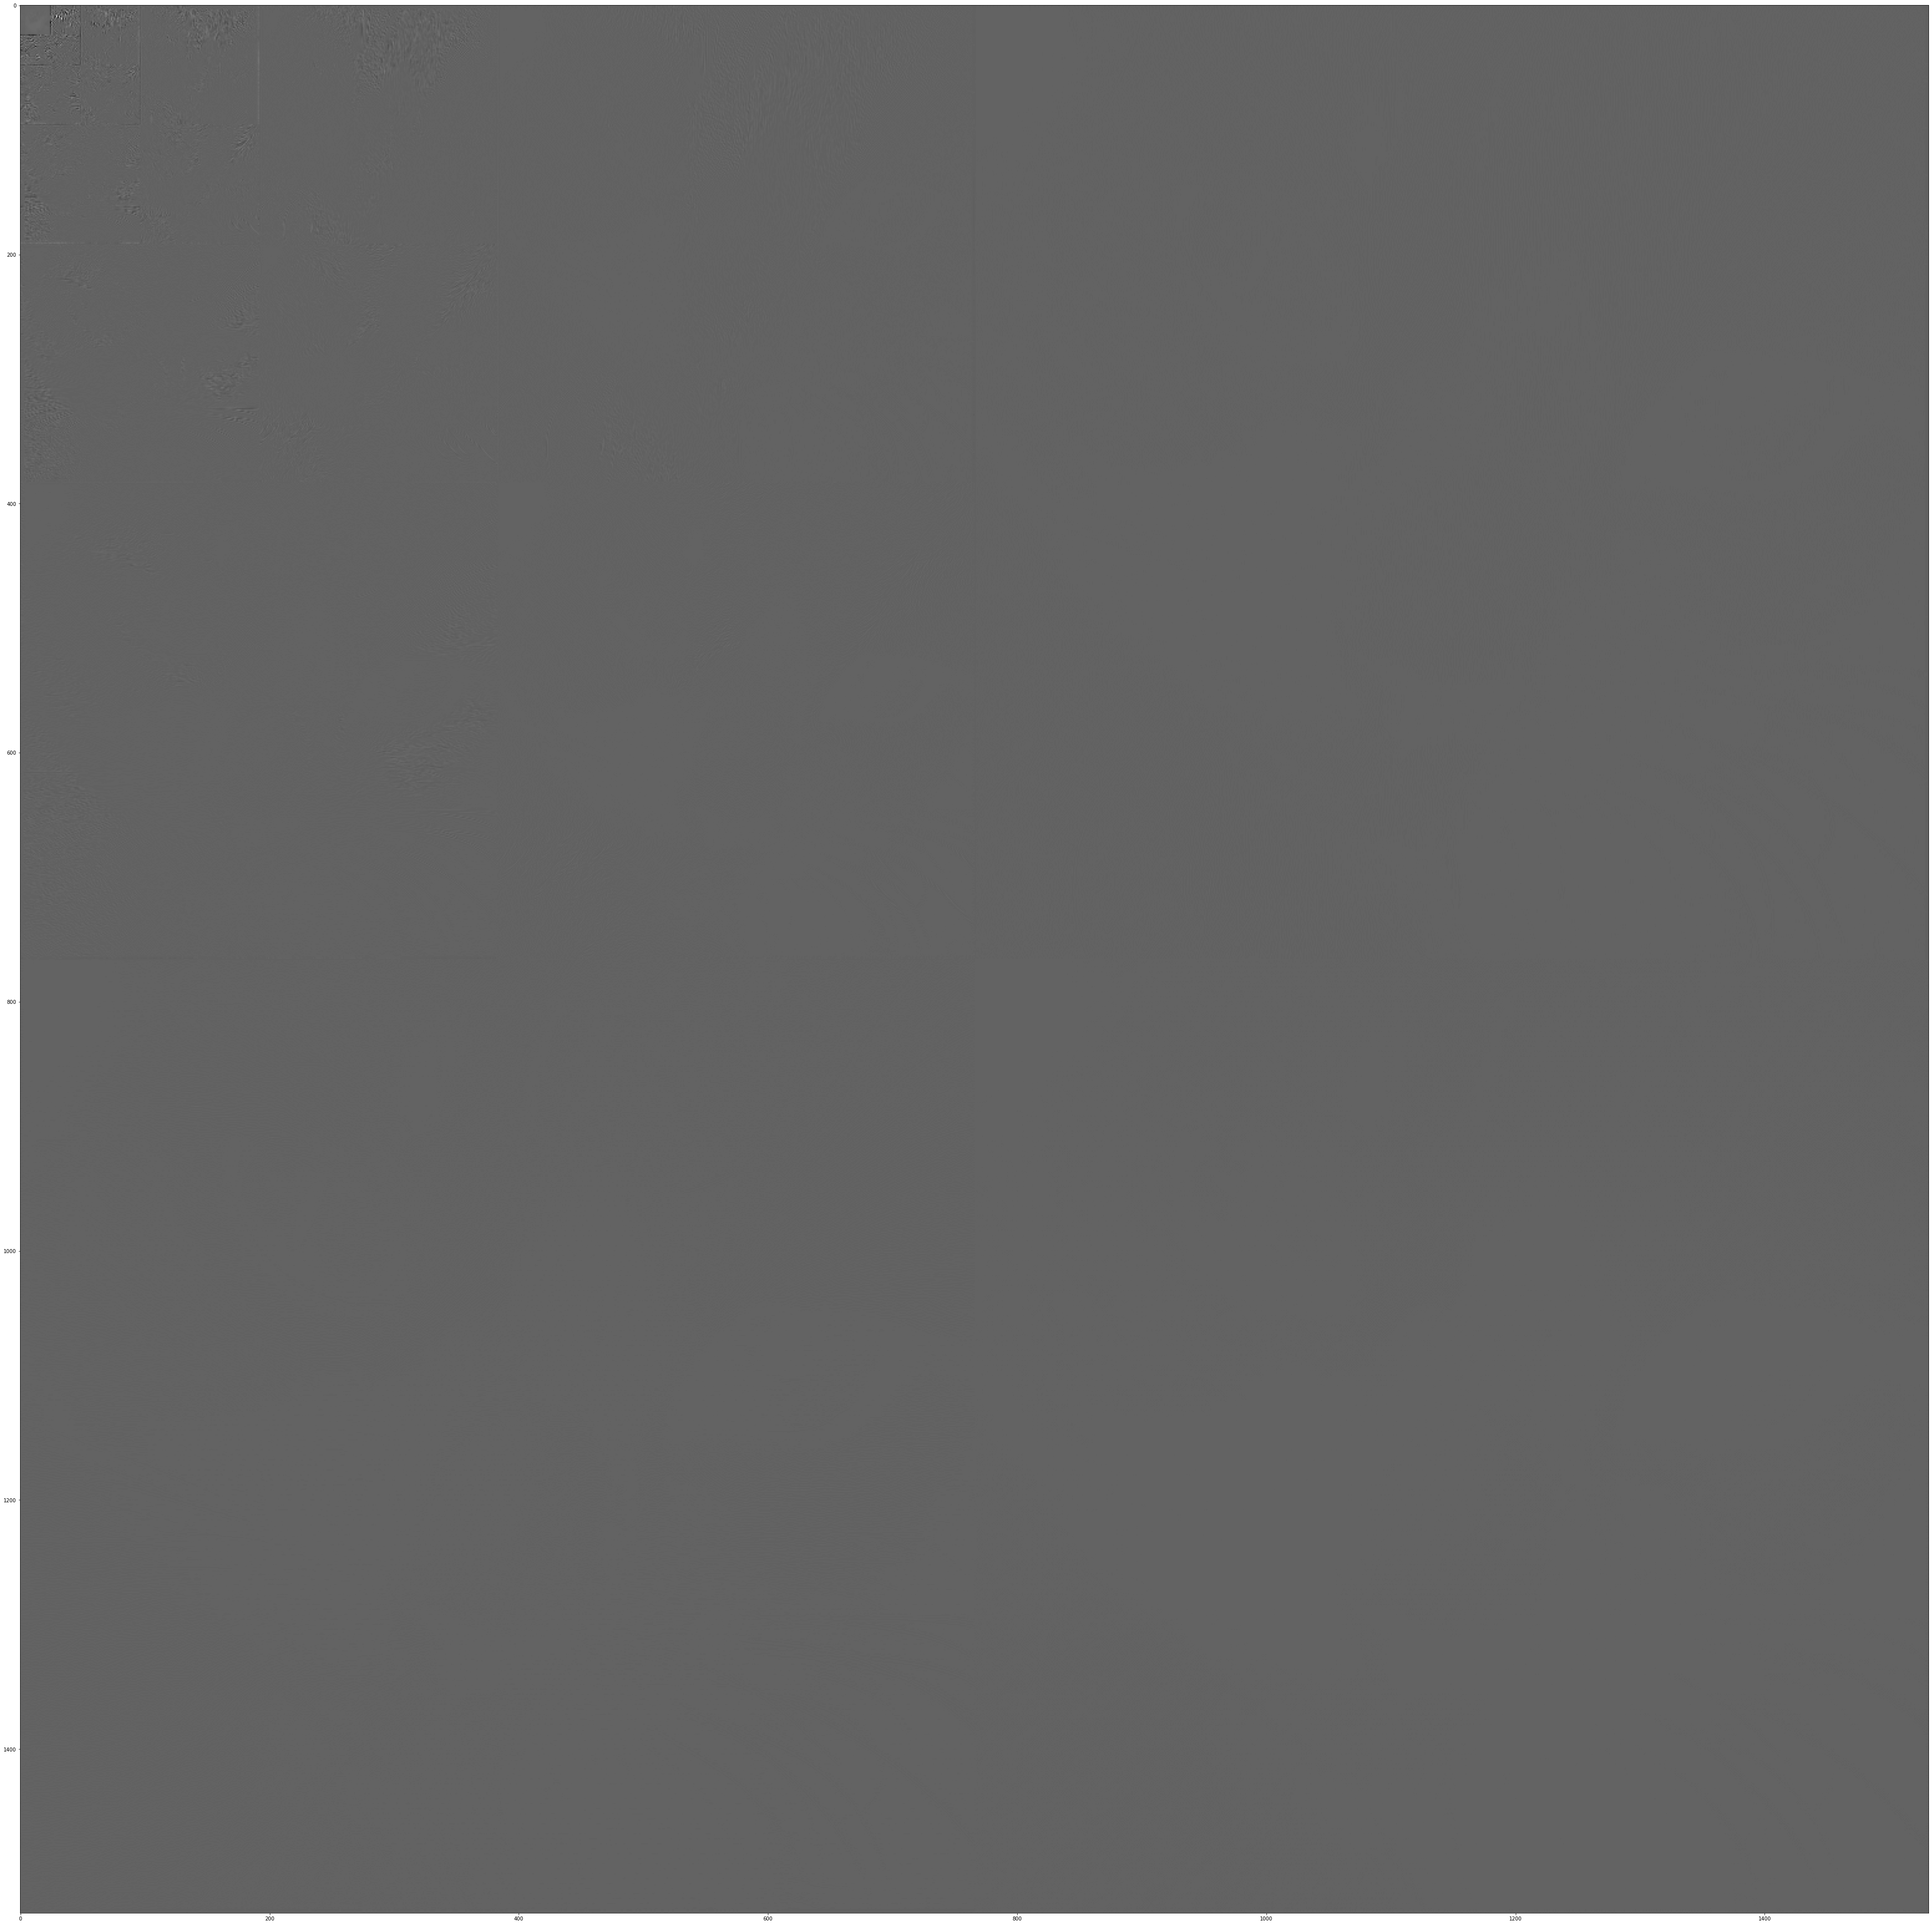

In [12]:
cA6, (cH6,cV6,cD6), (cH5,cV5,cD5), (cH4,cV4,cD4), (cH3,cV3,cD3), (cH2,cV2,cD2), (cH1,cV1,cD1) = pywt.wavedec2(input_image, 'db6', level=6, mode='periodization')

def normalise(tab):
    c = (tab - tab.min()) * (255 / (tab.max() - tab.min()))
    return c

cA6 = normalise(cA6) 

level6 = np.vstack((cA6, cH6))
level6 = np.hstack((level6, np.vstack((cV6, cD6))))

level5 = np.vstack((level6, cH5))
level5 = np.hstack((level5, np.vstack((cV5, cD5))))

level4 = np.vstack((level5, cH4))
level4 = np.hstack((level4, np.vstack((cV4, cD4))))
                   
level3 = np.vstack((level4, cH3))
level3 = np.hstack((level3, np.vstack((cV3, cD3))))


level3 = level3[:383,:383]
                   
level2 = np.vstack((level3, cH2))
level2 = np.hstack((level2, np.vstack((cV2, cD2))))
                   
level1 = np.vstack((level2, cH1))
level1 = np.hstack((level1, np.vstack((cV1, cD1))))


plt.figure(figsize=(70, 70))
plt.imshow(level1, cmap='gray')
plt.show()

* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



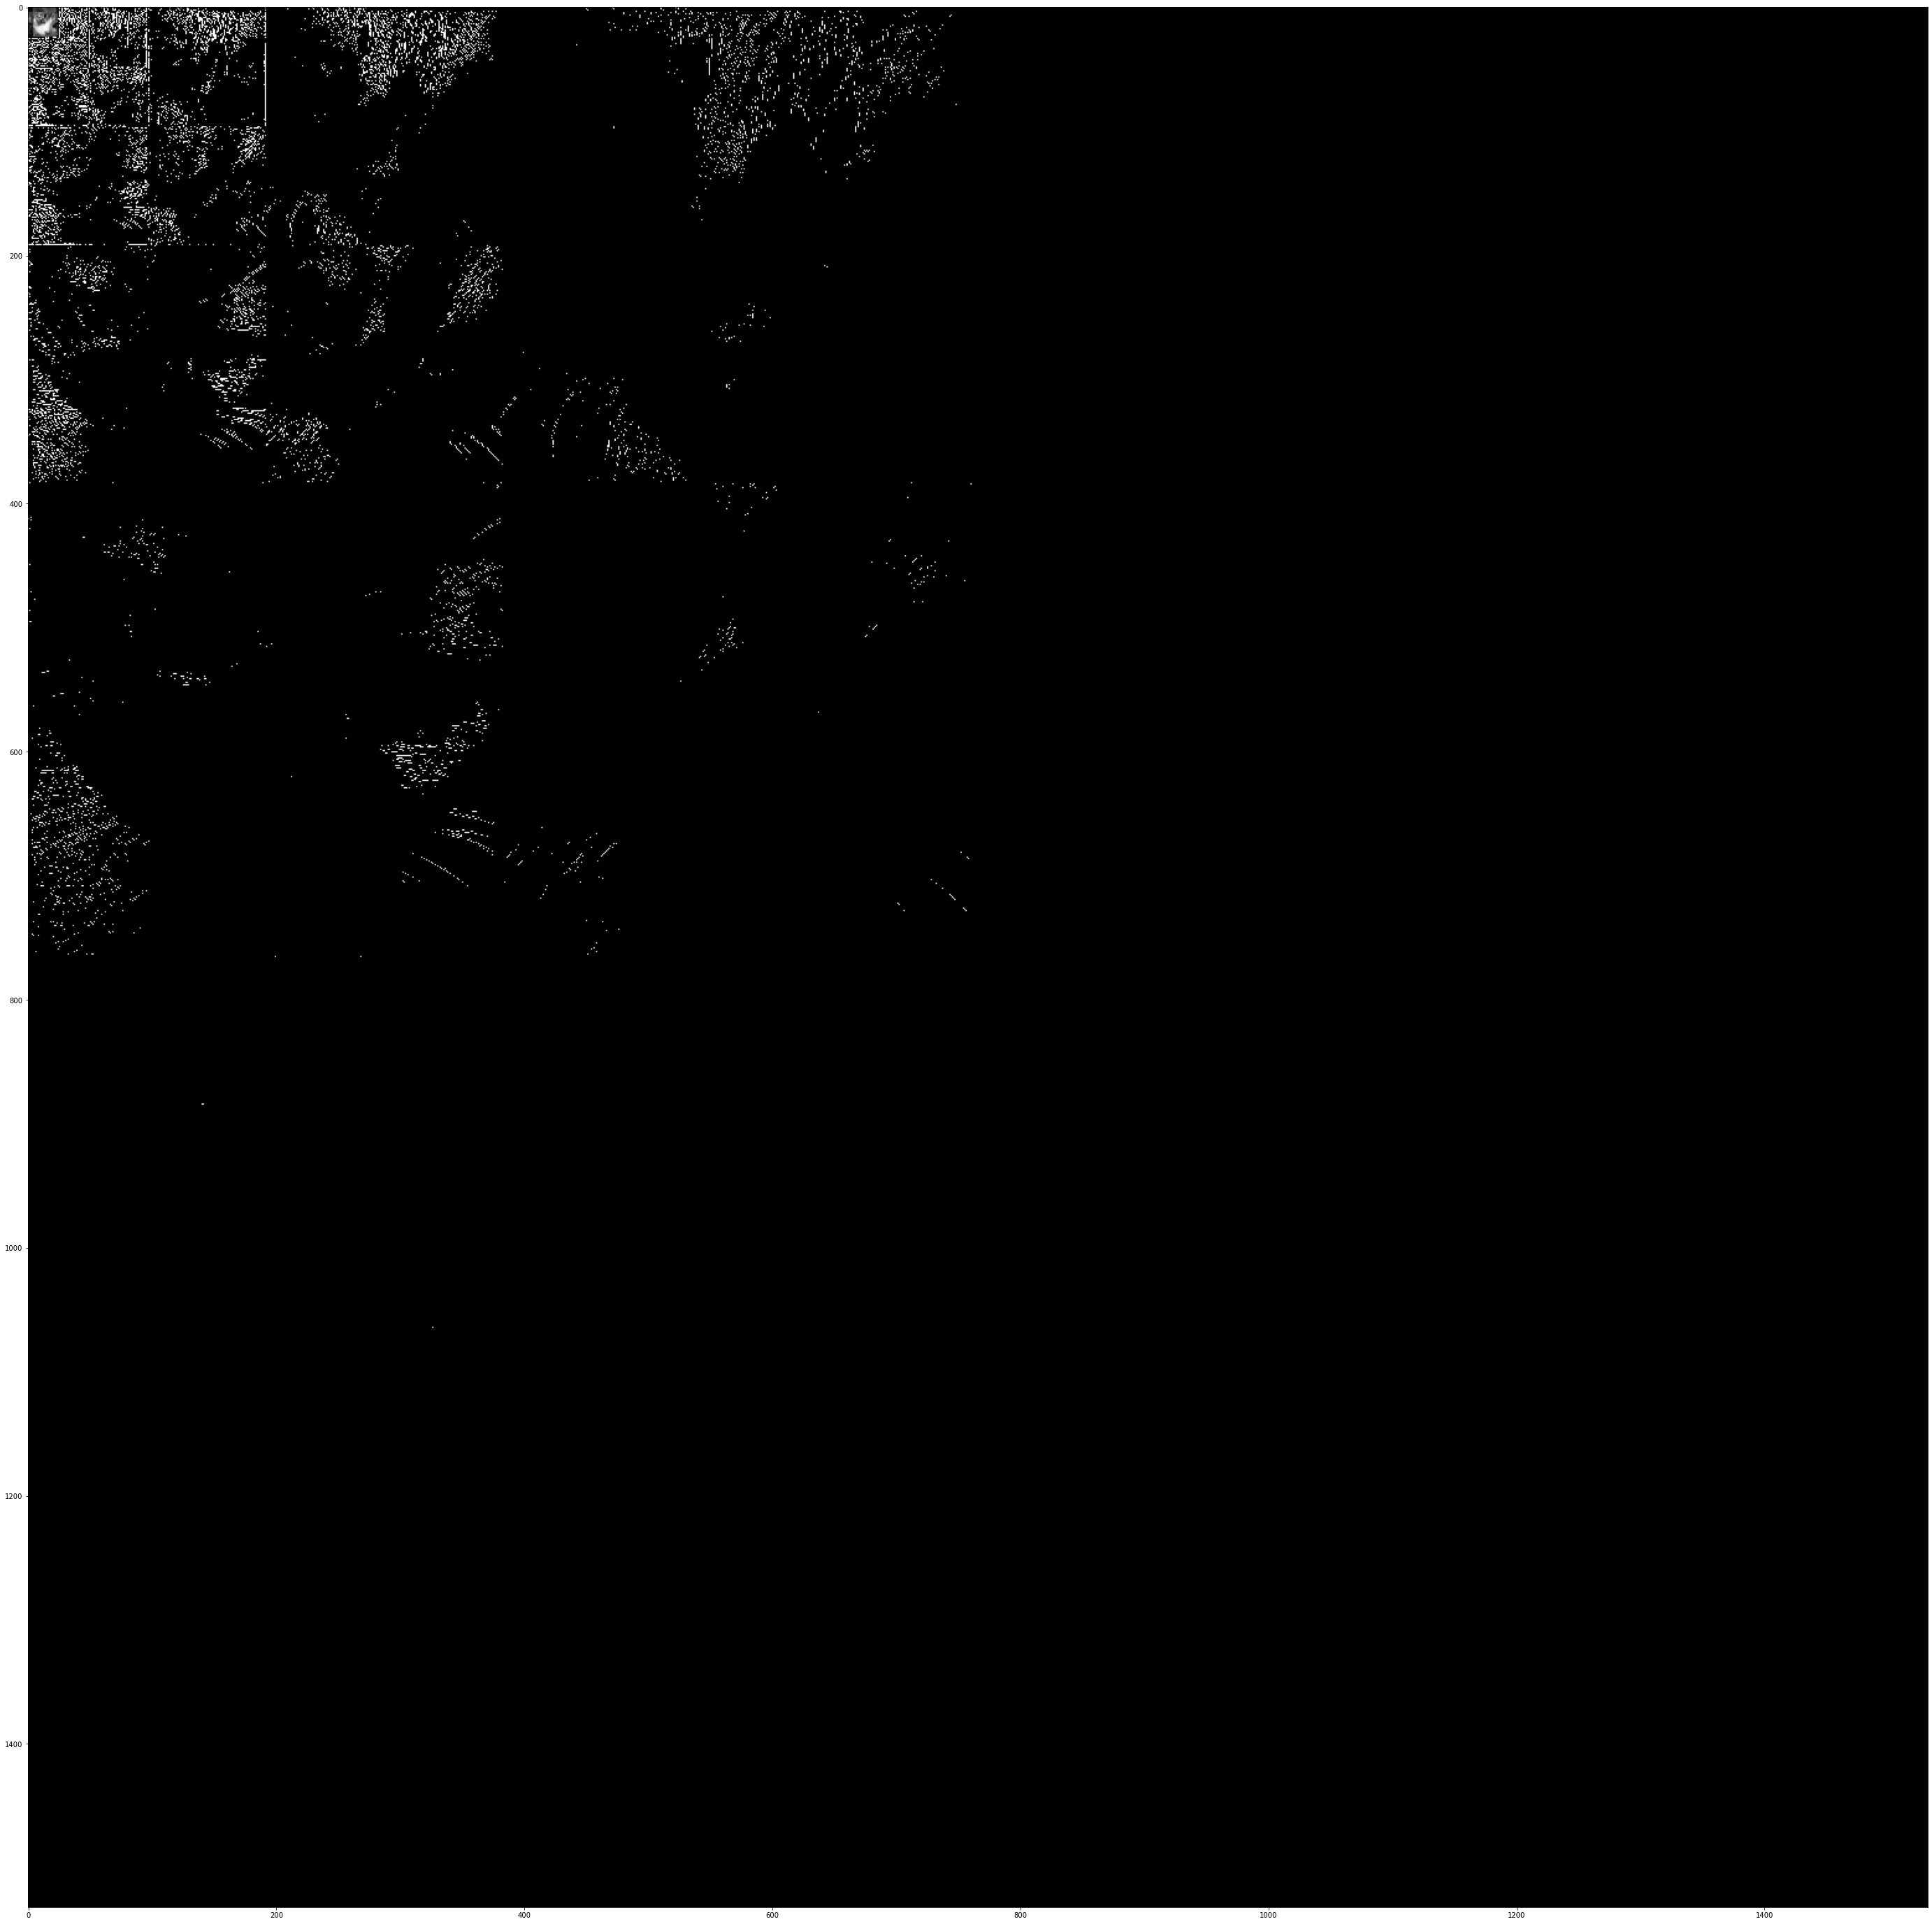

In [13]:
# Your code here
cA6, (cH6,cV6,cD6), (cH5,cV5,cD5), (cH4,cV4,cD4), (cH3,cV3,cD3), (cH2,cV2,cD2), (cH1,cV1,cD1) = pywt.wavedec2(input_image, 'db6', level=6, mode='periodization')


cA6 = normalise(cA6)


threshold = 100
cH1 = np.where(cH1 > threshold, 255, 0)
cV1 = np.where(cV1 > threshold, 255, 0)
cD1 = np.where(cD1 > threshold, 255, 0)

cH2 = np.where(cH2 > threshold, 255, 0)
cV2 = np.where(cV2 > threshold, 255, 0)
cD2 = np.where(cD2 > threshold, 255, 0)

cH3 = np.where(cH3 > threshold, 255, 0)
cV3 = np.where(cV3 > threshold, 255, 0)
cD3 = np.where(cD3 > threshold, 255, 0)

cH4 = np.where(cH4 > threshold, 255, 0)
cV4 = np.where(cV4 > threshold, 255, 0)
cD4 = np.where(cD4 > threshold, 255, 0)

cH5 = np.where(cH5 > threshold, 255, 0)
cV5 = np.where(cV5 > threshold, 255, 0)
cD5 = np.where(cD5 > threshold, 255, 0)

cH6 = np.where(cH6 > threshold, 255, 0)
cV6 = np.where(cV6 > threshold, 255, 0)
cD6 = np.where(cD6 > threshold, 255, 0)

level6 = np.vstack((cA6, cH6))
level6 = np.hstack((level6, np.vstack((cV6, cD6))))

level5 = np.vstack((level6, cH5))
level5 = np.hstack((level5, np.vstack((cV5, cD5))))

level4 = np.vstack((level5, cH4))
level4 = np.hstack((level4, np.vstack((cV4, cD4))))
                   
level3 = np.vstack((level4, cH3))
level3 = np.hstack((level3, np.vstack((cV3, cD3))))


level3 = level3[:383,:383]
                   
level2 = np.vstack((level3, cH2))
level2 = np.hstack((level2, np.vstack((cV2, cD2))))
                   
level1 = np.vstack((level2, cH1))
level1 = np.hstack((level1, np.vstack((cV1, cD1))))


plt.figure(figsize=(50, 50))
plt.imshow(level1, cmap='gray')
plt.show()

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

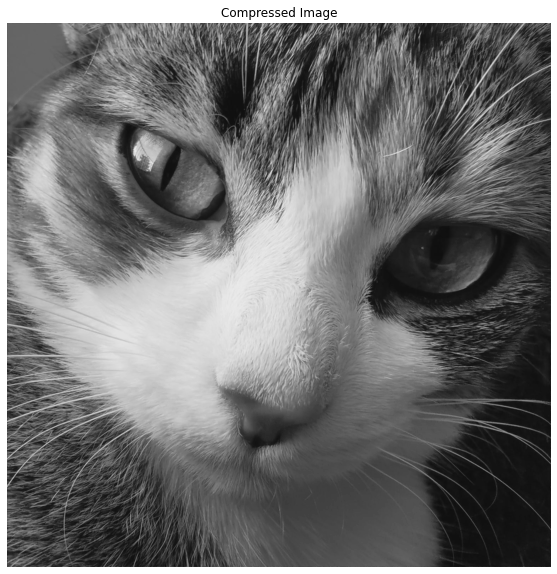

In [14]:
# Your code here
coeffs = pywt.wavedec2(input_image, 'db6', level=6, mode='periodization')

coeffs[-1] = tuple([np.zeros_like(v) for v in coeffs[-1]])


compressed_image = pywt.waverec2(coeffs, 'db6', mode='periodization')

#plot compressed image
show_image(compressed_image, 'Compressed Image')


What's the compression ratio?

In [15]:
input_size = input_image.size

compressed_size = np.count_nonzero(cA6) + \
                  np.count_nonzero(cH6) + np.count_nonzero(cV6) + np.count_nonzero(cD6) + \
                  np.count_nonzero(cH5) + np.count_nonzero(cV5) + np.count_nonzero(cD5) + \
                  np.count_nonzero(cH4) + np.count_nonzero(cV4) + np.count_nonzero(cD4) + \
                  np.count_nonzero(cH3) + np.count_nonzero(cV3) + np.count_nonzero(cD3) + \
                  np.count_nonzero(cH2) + np.count_nonzero(cV2) + np.count_nonzero(cD2) + \
                  np.count_nonzero(cH1) + np.count_nonzero(cV1) + np.count_nonzero(cD1)

compression_ratio = input_size / compressed_size
print("Compression Ratio:", compression_ratio)


Compression Ratio: 182.0751436112405


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [23]:
from skimage.transform import resize

def psnr(original_image, compressed_image):
    # Resize compressed_image to match the shape of original_image
    compressed_image_resized = resize(compressed_image, original_image.shape, anti_aliasing=True)
    h, w = original_image.shape
    mse = np.sum(np.abs(original_image - compressed_image_resized) ** 2) / (h * w)
    return 20 * np.log10(255 ** 2 / mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [41]:
def codec(input_image, wavelet='db4', num_levels=6, threshold=100):
    coeffs = pywt.wavedec2(input_image, wavelet, level=num_levels, mode='periodization')
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    arr2 = np.where(np.abs(arr) > threshold, arr, 0)
    coeffs2 = pywt.array_to_coeffs(arr2, coeff_slices, output_format='wavedec2')
    compressed_image = pywt.waverec2(coeffs2, wavelet, mode='periodization')
    compressed_size = np.sum([np.count_nonzero(c) for c in coeffs2])
    input_size = np.count_nonzero(input_image)
    compression_ratio = input_size / compressed_size
    
    return compressed_image, compression_ratio
  

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [43]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here
for thresh in thresholds:
  for wav in [wavelet_1,wavelet_2]:
    compressed_image,compression_ratio = codec(input_image,wavelet=wav,num_levels=num_levels,threshold=thresh) 
    print(f"Wavelet: {wav}, Threshold: {thresh}, Compression Ratio: {compression_ratio}, PSNR: {psnr(input_image,compressed_image)}")

Wavelet: db4, Threshold: 5, Compression Ratio: 3.788014677888393, PSNR: 61.780530228349384
Wavelet: bior1.3, Threshold: 5, Compression Ratio: 2.7931533326643634, PSNR: 61.74897112351756
Wavelet: db4, Threshold: 10, Compression Ratio: 6.2112548845635835, PSNR: 61.23834545967351
Wavelet: bior1.3, Threshold: 10, Compression Ratio: 4.349972279791782, PSNR: 61.07127562570719
Wavelet: db4, Threshold: 20, Compression Ratio: 11.8152100861568, PSNR: 59.729207110722406
Wavelet: bior1.3, Threshold: 20, Compression Ratio: 7.873902179476818, PSNR: 59.15041408329845
Wavelet: db4, Threshold: 40, Compression Ratio: 26.189777996818925, PSNR: 56.74309855347551
Wavelet: bior1.3, Threshold: 40, Compression Ratio: 17.86336063319378, PSNR: 55.38824311725992
Wavelet: db4, Threshold: 80, Compression Ratio: 65.82503307902368, PSNR: 52.377800819922555
Wavelet: bior1.3, Threshold: 80, Compression Ratio: 49.70284633207916, PSNR: 50.88619844181388
Wavelet: db4, Threshold: 100, Compression Ratio: 94.54031214620734,

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?

Answer: For PSNR the results are almost always the same except for large thresholds where bior1.3 is less effective than db4. Moreover db4 manages to get higher compression ration than bior1.3 in every case which means that db4 is better for compression. 

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.